# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [65]:
DATA_DIR = '/content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [66]:
'''
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

'''

'\nimport os.path\nfrom os import path\n\nfor pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:\n  if path.exists(pth) == False:\n    os.mkdir(pth)\n\n'

In [67]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [68]:
!unzip "/content/train/train.zip" -d "/content/train/"
!unzip "/content/test/test.zip" -d "/content/test/"

unzip:  cannot find or open /content/train/train.zip, /content/train/train.zip.zip or /content/train/train.zip.ZIP.
unzip:  cannot find or open /content/test/test.zip, /content/test/test.zip.zip or /content/test/test.zip.ZIP.


# Data Prep

## Import Libraries

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')



## Read the Data

In [70]:
TRAIN_DIR = "data/train"
TEST_DIR = "data/test"
DATA_DIR = "data"
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

## Data Understanding

In [71]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [72]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [73]:
#invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])#, format='%d/%m/%Y')
#invoice_test['invoice_date'] = pd.to_datetime(invoice_test['invoice_date'])#, format='%d/%m/%Y')

In [74]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [75]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [76]:
invoice_train["counter_coefficient"].sort_values()
invoice_train["counter_coefficient"].nunique()

16

In [77]:

invoice_train["reading_remarque"].sort_values(ascending=True)

3704439      5
4476748      6
3262542      6
1659782      6
3262538      6
          ... 
2556034    413
2556043    413
2556044    413
2556035    413
2556037    413
Name: reading_remarque, Length: 4476749, dtype: int64

In [78]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [79]:
#client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])#, format='%d/%m/%Y')
#client_test['creation_date'] = pd.to_datetime(client_test['creation_date'])#, format='%d/%m/%Y')

In [80]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [81]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [82]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [83]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [84]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [85]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [86]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [87]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [88]:
client_train["client_id"].duplicated().value_counts()
client_test["client_id"].duplicated().value_counts()

client_id
False    58069
Name: count, dtype: int64

In [89]:
client_test["client_id"].duplicated().value_counts()

client_id
False    58069
Name: count, dtype: int64

No missing values in train set

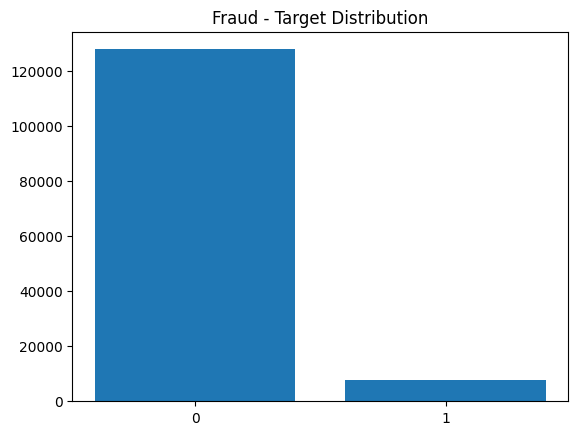

In [90]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

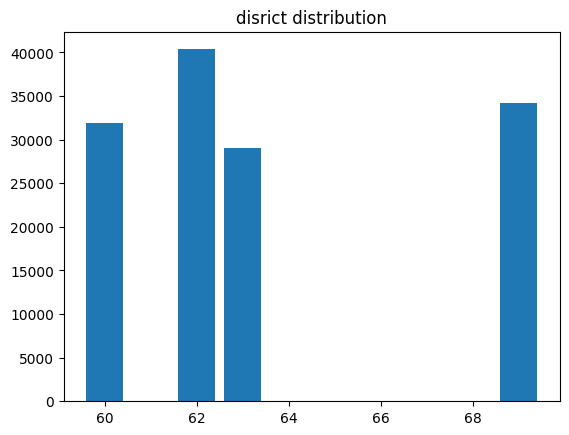

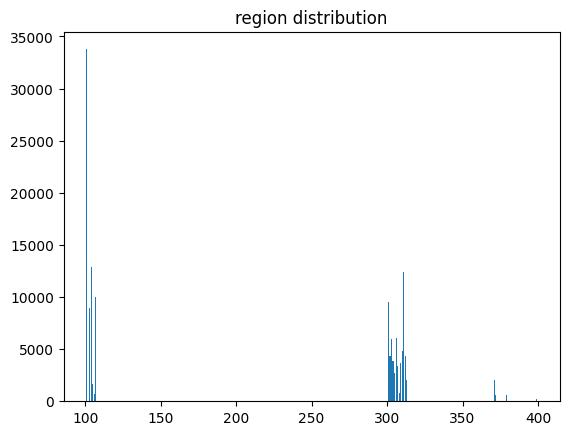

In [91]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [92]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [93]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [94]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [95]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [96]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [97]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [98]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [99]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [100]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [101]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [102]:
train.shape, test.shape

((135493, 9), (58069, 8))

In [103]:
train.columns, test.columns

(Index(['disrict', 'client_catg', 'region', 'target', '1transactions_count',
        'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean'],
       dtype='object'),
 Index(['disrict', 'client_catg', 'region', '1transactions_count',
        'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean'],
       dtype='object'))

# Modelling

In [104]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.tree import plot_tree

## Pre-process data

* import required modules*

In [105]:
# Set random seed to ensure reproducible runs
RSEED = 50

In [106]:
train = pd.read_csv("data/df.csv")
train.head()

,client_id,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,months_number_max,months_number_min,months_number_mean,consumption_sum,...,counter_type_0_nunique,counter_type_1_count,counter_type_1_nunique,counter_type_2_count,counter_type_2_nunique,disrict,client_catg,region,creation_date,target
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000,12.0,2.0,4.628571,12704.0,...,1,35,1,35,1,60,11,101,31/12/1994,0.0
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000,8.0,2.0,4.324324,20629.0,...,1,37,1,37,1,69,11,107,29/05/2002,0.0
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000,12.0,4.0,6.444444,15057.0,...,1,18,1,18,1,62,11,301,13/03/1986,0.0
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000,6.0,4.0,4.200000,24.0,...,1,20,1,20,1,69,11,105,11/07/1996,0.0
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286,4.0,2.0,3.714286,12917.0,...,1,14,1,14,1,62,11,303,14/10/2014,0.0


*do with it whatever it is need to be done with it*

In [59]:
# Features for feature importance
features = list(train.columns)

*define X, Y*

In [109]:

mask = train.columns[train.dtypes == "int"].tolist()
mask

['transactions_count',
 'month_0_count',
 'month_0_nunique',
 'month_1_count',
 'month_1_nunique',
 'month_2_count',
 'month_2_nunique',
 'month_3_count',
 'month_3_nunique',
 'month_4_count',
 'month_4_nunique',
 'month_5_count',
 'month_5_nunique',
 'month_6_count',
 'month_6_nunique',
 'month_7_count',
 'month_7_nunique',
 'month_8_count',
 'month_8_nunique',
 'month_9_count',
 'month_9_nunique',
 'month_10_count',
 'month_10_nunique',
 'month_11_count',
 'month_11_nunique',
 'counter_statue_0_count',
 'counter_statue_0_nunique',
 'counter_statue_1_count',
 'counter_statue_1_nunique',
 'counter_statue_2_count',
 'counter_statue_2_nunique',
 'counter_statue_3_count',
 'counter_statue_3_nunique',
 'counter_statue_4_count',
 'counter_statue_4_nunique',
 'counter_statue_5_count',
 'counter_statue_5_nunique',
 'counter_statue_6_count',
 'counter_statue_6_nunique',
 'counter_type_0_count',
 'counter_type_0_nunique',
 'counter_type_1_count',
 'counter_type_1_nunique',
 'counter_type_2_coun

In [119]:
y = train['target']
X = train[mask]
X = train.drop(columns=['target', 'client_id', 'creation_date'])


y.shape, X.shape

((135351,), (135351, 62))

*split*

In [120]:
X_train, X_test, y_train,  y_test = train_test_split(X, y,test_size = 0.3)
X_train.shape, y_train.shape
#X_train
#y_train

((94745, 62), (94745,))

## Classifier: single decision treee

*define classifier*

In [121]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 2, random_state=RSEED)

*fit the model*

In [122]:
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Model Accuracy: 0.9433743205446198
Decision tree has 7 nodes with maximum depth 2.


*plot the tree*

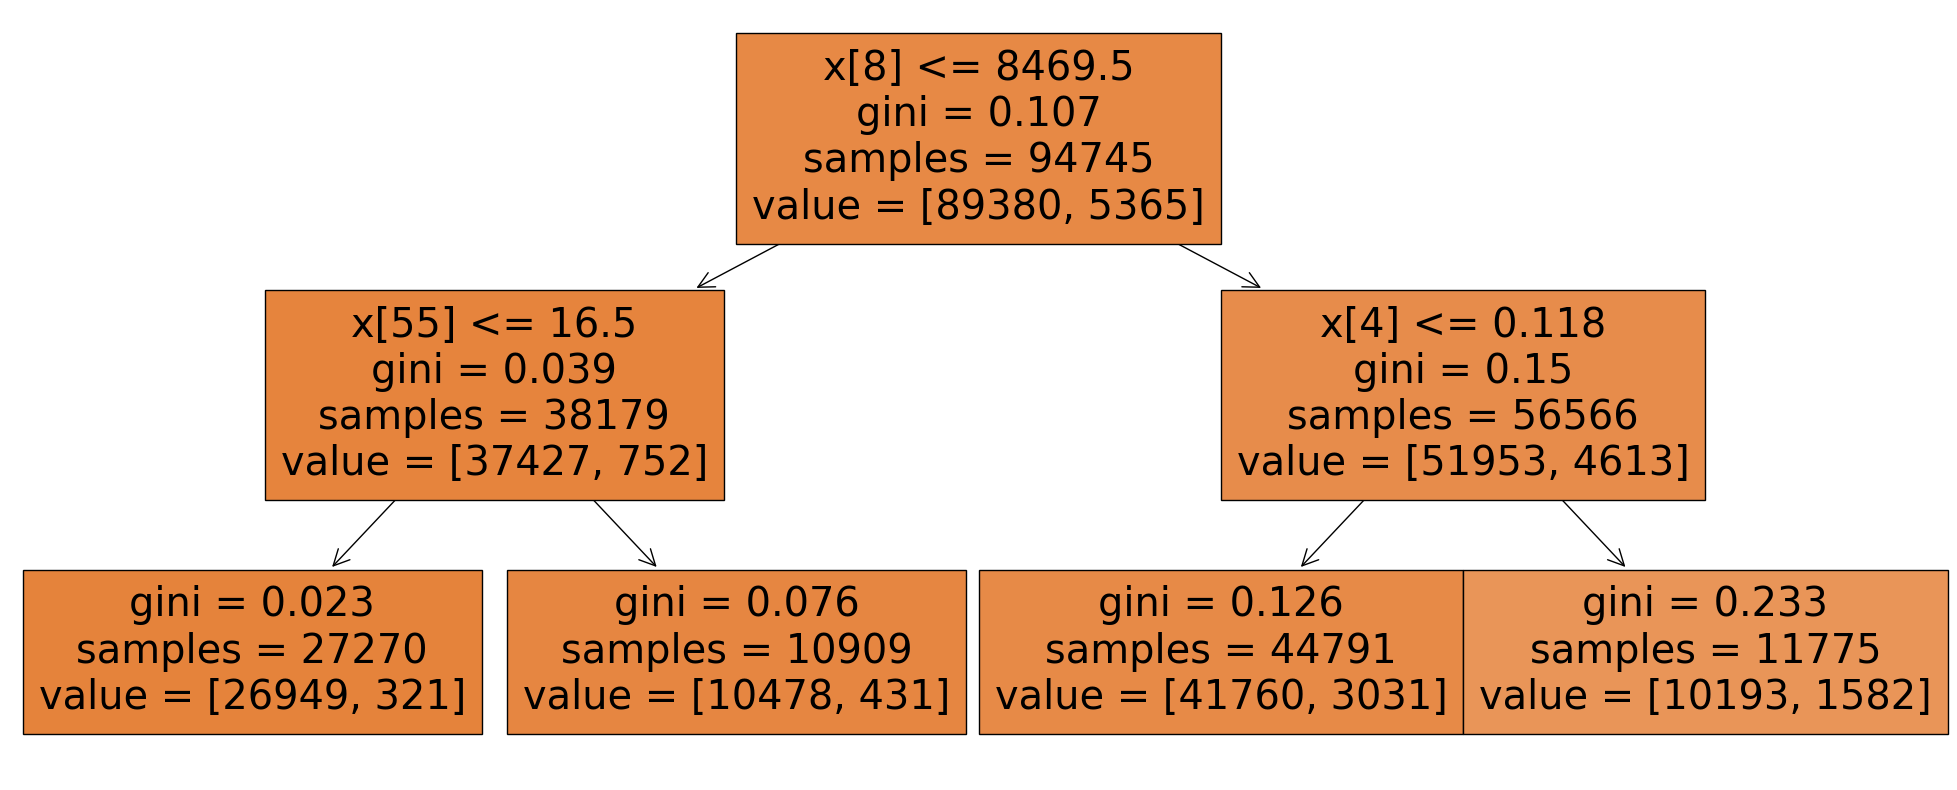

In [123]:
# Plot desision tree
fig = plt.figure(figsize=(25,10))
dectree_plot = plot_tree(tree, filled=True)

*predict*

In [50]:
y_pred_dt = tree.predict(X_test) # y_pred_dt = train_predictions - TODO adjust all containing train_predictions

*assess decision tree performance*

Baseline ROC AUC: 0.5
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     38352
         1.0       0.00      0.00      0.00      2296

    accuracy                           0.94     40648
   macro avg       0.47      0.50      0.49     40648
weighted avg       0.89      0.94      0.92     40648

--------------------------------------------------------------------------------


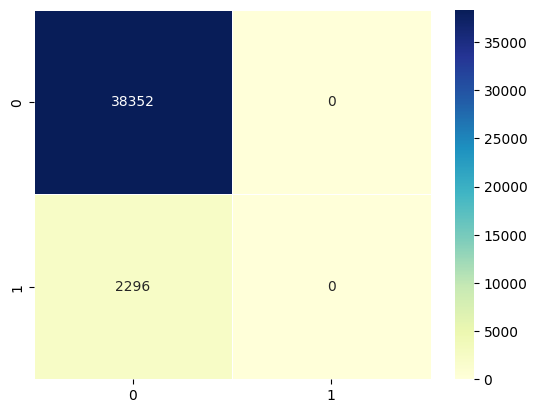

In [51]:
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

# Print classification report of our model
print(classification_report(y_test, y_pred_dt))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);


## Classifier: forest

*classifier*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rdfo = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

*fit*

In [ ]:
# Fit on training data
rdfo.fit(X_train, y_train)

*predict*

In [ ]:
y_pred_rdfo = rdfo.predict(X_test)

*assess*

In [ ]:
cm_rdfo = confusion_matrix(y_test, y_pred_rdfo)
sns.heatmap(cm_rdfo, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## Classifier: LGBM 

*classifier*

In [ ]:
model_lgbm = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)

*fit*

In [ ]:
model_lgbm.fit(X_train, y_train)

*predict*

In [ ]:
y_pred_lgbm = model_lgbm.predict(X_test)
#y_pred_lgbm = pd.DataFrame(y_pred_lgbm, columns=['target'])
#y_pred_lgbm.head()

*assess*

In [ ]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## Classifier KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

knn.fit(X_train, np.ravel(y_train))

y_pred = knn.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define parameter grid for randomized search
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

gs = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=5,
    verbose=5
)

gs.fit(X_train, y_train)

# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

## Random Search

*classifier & estimator*

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid for forest
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
'''
# KNN param grid
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

# Logistic Regression param grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}
'''

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)
#estimator =  KNeighborsClassifier()
#estimator = LogisticRegression()

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

rs.fit(X_train, y_train)

# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)


*best parameters*

In [ ]:
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)

*use best model*

In [ ]:
best_model = rs.best_estimator_

*predict*

In [ ]:
y_pred_rs = best_model.predict(X_test)

*asses*

In [ ]:
cm_rs = confusion_matrix(y_test, y_pred_rs)
sns.heatmap(cm_rs, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_rs)
sns.heatmap(cm_lr, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

## logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

cm_logr = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_logr, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Create Ouput file

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [132]:
OUTPUT_DIR = "data/output/"
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

# Modules required

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************